## 1. Initial Setup and Data Loading

### 1.1 Mounting Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.2 Importing Necessary Libraries

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_columns', None)

### 1.3 Loading the Dataset

In [4]:
df = pd.read_csv("/content/drive/MyDrive/synthetic_blood_demand_data.csv")

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

print("First 5 rows of the dataset:")
display(df.head())

First 5 rows of the dataset:


,Date,DayOfWeek,Month,Population,Events,HistoricalBloodUsage,HospitalAdmissions,BloodDonorsAvailable,Temperature,PredictedBloodDemand
0,2020-01-01,2,1,171958,0,174,98,34,24.799194,258
1,2020-01-02,3,1,196867,0,187,71,55,21.590136,197
2,2020-01-03,4,1,181932,0,132,82,82,38.866004,182
3,2020-01-04,5,1,153694,0,74,88,88,30.089531,60
4,2020-01-05,6,1,169879,0,117,68,93,38.348783,117


## 2. Initial Data Inspection and Saving

### 2.1 Inspecting Dataset Properties

In [5]:
print("Shape of dataset:", df.shape)
print("\nColumn names:\n", df.columns)
print("\nMissing values:\n", df.isnull().sum())
print("\nDate range:", df['Date'].min(), "to", df['Date'].max())
print("\nDataset Information:")
df.info()
print("\nDescriptive Statistics:")
display(df.describe())

Shape of dataset: (1827, 10)

Column names:
 Index(['Date', 'DayOfWeek', 'Month', 'Population', 'Events',
       'HistoricalBloodUsage', 'HospitalAdmissions', 'BloodDonorsAvailable',
       'Temperature', 'PredictedBloodDemand'],
      dtype='object')

Missing values:
 Date                    0
DayOfWeek               0
Month                   0
Population              0
Events                  0
HistoricalBloodUsage    0
HospitalAdmissions      0
BloodDonorsAvailable    0
Temperature             0
PredictedBloodDemand    0
dtype: int64

Date range: 2020-01-01 00:00:00 to 2024-12-31 00:00:00

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  1827 non-null   datetime64[ns]
 1   DayOfWeek             1827 non-null   int64         
 2   Month                 1827 non-null

,Date,DayOfWeek,Month,Population,Events,HistoricalBloodUsage,HospitalAdmissions,BloodDonorsAvailable,Temperature,PredictedBloodDemand
count,1827,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000
mean,2022-07-02 00:00:00.000000256,3.000000,6.521073,125902.013136,0.047619,177.652436,64.894362,84.253421,27.414917,183.963875
min,2020-01-01 00:00:00,0.000000,1.000000,50126.000000,0.000000,50.000000,30.000000,20.000000,15.033888,50.000000
25%,2021-04-01 12:00:00,1.000000,4.000000,87792.500000,0.000000,117.000000,47.000000,52.000000,21.246625,119.000000
50%,2022-07-02 00:00:00,3.000000,7.000000,126323.000000,0.000000,180.000000,65.000000,85.000000,27.409973,184.000000
75%,2023-10-01 12:00:00,5.000000,10.000000,164177.500000,0.000000,238.000000,82.000000,115.000000,33.688241,244.500000
max,2024-12-31 00:00:00,6.000000,12.000000,199859.000000,1.000000,299.000000,99.000000,149.000000,39.993532,427.000000
std,NaN,2.000548,3.450157,43531.328946,0.213017,71.575611,20.301757,37.026689,7.224292,80.178284


### 2.2 Saving Base Cleaned Data

In [6]:
base_path = "/content/drive/MyDrive/project_outputs"
import os
os.makedirs(base_path, exist_ok=True)

df.to_csv(f"{base_path}/01_base_cleaned_data.csv", index=False)
print("Base cleaned dataset saved.")

Base cleaned dataset saved.


## 3. Feature Engineering (Calendar Features)

### 3.1 Creating Weekday, Weekend, and Month Features

In [7]:
df['weekday'] = df['Date'].dt.weekday        # 0 = Monday
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)
df['month'] = df['Date'].dt.month

### 3.2 Adding Season Feature

In [8]:
def get_season(month):
    if month in [3, 4, 5]:
        return 'summer'
    elif month in [6, 7, 8, 9]:
        return 'monsoon'
    else:
        return 'winter'

df['season'] = df['month'].apply(get_season)

### 3.3 Adding Holiday Feature

In [9]:
!pip install holidays

In [10]:
import holidays

india_holidays = holidays.CountryHoliday('IN')

df['is_holiday'] = df['Date'].dt.date.apply(
    lambda x: 1 if x in india_holidays else 0
)

### 3.4 One-Hot Encoding Season Feature

In [11]:
# Drop any existing season_ columns to avoid duplicates from previous runs
df = df.loc[:, ~df.columns.str.startswith('season_')]

df = pd.get_dummies(df, columns=['season'], drop_first=True, dtype=int)

print("Calendar Features added and encoded (first 5 rows):")
# Dynamically create the list of season columns actually present after get_dummies
present_season_cols = [col for col in df.columns if col.startswith('season_')]
display(df[['Date', 'weekday', 'is_weekend', 'month', 'is_holiday'] + present_season_cols].head())

Calendar Features added and encoded (first 5 rows):


,Date,weekday,is_weekend,month,is_holiday,season_summer,season_winter
0,2020-01-01,2,0,1,0,0,1
1,2020-01-02,3,0,1,0,0,1
2,2020-01-03,4,0,1,0,0,1
3,2020-01-04,5,1,1,0,0,1
4,2020-01-05,6,1,1,0,0,1


### 3.5 Saving Feature-Enhanced Data

In [12]:
df.to_csv(f"{base_path}/02_external_features_added.csv", index=False)
print("External-feature-enhanced dataset saved.")

External-feature-enhanced dataset saved.


## 4. Feature Engineering (Lag Features)

### 4.1 Creating Lagged Demand Features

In [13]:
TARGET = 'PredictedBloodDemand'

df = df.sort_values('Date').reset_index(drop=True)

df['lag_1'] = df[TARGET].shift(1)                # yesterday
df['lag_3_avg'] = df[TARGET].rolling(3).mean().shift(1)
df['lag_7_avg'] = df[TARGET].rolling(7).mean().shift(1)
df['lag_14_avg'] = df[TARGET].rolling(14).mean().shift(1)

df_lagged = df.dropna().reset_index(drop=True)

print("Lag Features added (first 5 rows after dropping NaNs):")
display(df_lagged[['Date', TARGET, 'lag_1', 'lag_3_avg', 'lag_7_avg', 'lag_14_avg']].head())

Lag Features added (first 5 rows after dropping NaNs):


,Date,PredictedBloodDemand,lag_1,lag_3_avg,lag_7_avg,lag_14_avg
0,2020-01-15,238,278.0,161.666667,173.714286,159.642857
1,2020-01-16,102,238.0,213.666667,178.857143,158.214286
2,2020-01-17,98,102.0,206.000000,183.142857,151.428571
3,2020-01-18,364,98.0,146.000000,166.285714,145.428571
4,2020-01-19,174,364.0,188.000000,183.857143,167.142857


### 4.2 Saving Lag-Feature Enhanced Data

In [14]:
df_lagged.to_csv(
    f"{base_path}/03_lag_features_added.csv",
    index=False
)

print("Lag-feature dataset saved.")

Lag-feature dataset saved.


## 5. STL Decomposition and Hybrid Data Preparation

### 5.1 Performing STL Decomposition

STL decomposition components added to df_hybrid (first 5 rows):


,Date,PredictedBloodDemand,trend,seasonal,residual
0,2020-01-15,238,123.341610,101.982042,12.676349
1,2020-01-16,102,130.089239,-29.791883,1.702645
2,2020-01-17,98,136.840398,-11.429024,-27.411374
3,2020-01-18,364,143.515977,-166.513317,386.997340
4,2020-01-19,174,150.119073,-1.768794,25.649721



Plotting STL Decomposition:


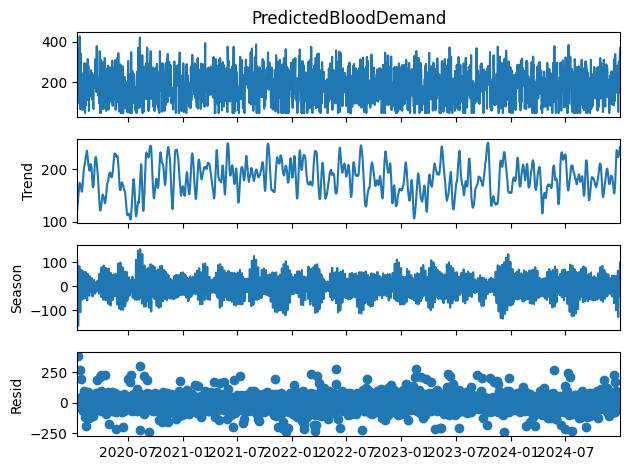

In [15]:
from statsmodels.tsa.seasonal import STL

ts = df_lagged.set_index('Date')[TARGET]

stl = STL(ts, period=7, robust=True)
stl_result = stl.fit()

# Create a DataFrame for STL components
stl_df_components = pd.DataFrame({
    'Date': ts.index,
    'trend': stl_result.trend,
    'seasonal': stl_result.seasonal,
    'residual': stl_result.resid
}).reset_index(drop=True) # Reset index to ensure 'Date' is only a column

# Merge df_lagged with STL components
df_hybrid = df_lagged.merge(
    stl_df_components[['Date', 'trend', 'seasonal', 'residual']],
    on='Date',
    how='inner'
)

# Drop any NaNs introduced by STL decomposition (usually at start/end)
df_hybrid = df_hybrid.dropna().reset_index(drop=True)

print("STL decomposition components added to df_hybrid (first 5 rows):")
display(df_hybrid[['Date', TARGET, 'trend', 'seasonal', 'residual']].head())

print("\nPlotting STL Decomposition:")
stl_result.plot()
plt.show()

### 5.2 Saving STL-Decomposed Data

In [16]:
df_hybrid.to_csv(
    f"{base_path}/04_stl_decomposed_data.csv",
    index=False
)

print("STL-decomposed dataset saved.")

STL-decomposed dataset saved.


## 6. Define Target, Features and Data Split

### 6.1 Defining Features and Splitting Data

In [17]:
TARGET = 'PredictedBloodDemand'

# Dynamically get unique season columns after one-hot encoding from df_hybrid
# This ensures FEATURES_DIRECT contains only existing, unique season columns
season_cols = sorted(list(set([col for col in df_hybrid.columns if col.startswith('season_')])))

FEATURES_DIRECT = [
    # Calendar features
    'weekday', 'is_weekend', 'month', 'is_holiday'
] + season_cols + [
    # Lag features
    'lag_1', 'lag_3_avg', 'lag_7_avg', 'lag_14_avg'
]

# Define split date (80% train, 20% test based on time)
split_date = df_hybrid['Date'].quantile(0.8)

# Split data for direct prediction models
train_df = df_hybrid[df_hybrid['Date'] <= split_date].copy()
test_df = df_hybrid[df_hybrid['Date'] > split_date].copy()

X_train_direct = train_df[FEATURES_DIRECT]
y_train_direct = train_df[TARGET]

X_test_direct = test_df[FEATURES_DIRECT]
y_test_direct = test_df[TARGET]

# Split data for residual prediction models
X_train_res = train_df[FEATURES_DIRECT]
y_train_res = train_df['residual']

X_test_res = test_df[FEATURES_DIRECT]

print(f"Split Date: {split_date}")
print(f"Train DataFrame shape: {train_df.shape}")
print(f"Test DataFrame shape: {test_df.shape}")
print(f"X_train_direct shape: {X_train_direct.shape}, y_train_direct shape: {y_train_direct.shape}")
print(f"X_test_direct shape: {X_test_direct.shape}, y_test_direct shape: {y_test_direct.shape}")
print(f"X_train_res shape: {X_train_res.shape}, y_train_res shape: {y_train_res.shape}")
print(f"X_test_res shape: {X_test_res.shape}")

Split Date: 2024-01-03 14:24:00
Train DataFrame shape: (1450, 23)
Test DataFrame shape: (363, 23)
X_train_direct shape: (1450, 10), y_train_direct shape: (1450,)
X_test_direct shape: (363, 10), y_test_direct shape: (363,)
X_train_res shape: (1450, 10), y_train_res shape: (1450,)
X_test_res shape: (363, 10)


## 7. Evaluation Metrics Helper Functions

### 7.1 Defining Evaluation Functions

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_model(y_true_train, y_pred_train, y_true_test, y_pred_test, model_name):
    train_mae = mean_absolute_error(y_true_train, y_pred_train)
    train_rmse = np.sqrt(mean_squared_error(y_true_train, y_pred_train))
    test_mae = mean_absolute_error(y_true_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
    print(f"\n--- {model_name} Performance ---")
    print(f"Train MAE: {train_mae:.4f}")
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    return train_mae, train_rmse, test_mae, test_rmse

def evaluate_hybrid_model(train_df_part, residual_preds_train, test_df_part, residual_preds_test, target_col, model_name):
    final_pred_train = train_df_part['trend'] + train_df_part['seasonal'] + residual_preds_train
    train_mae = mean_absolute_error(train_df_part[target_col], final_pred_train)
    train_rmse = np.sqrt(mean_squared_error(train_df_part[target_col], final_pred_train))

    final_pred_test = test_df_part['trend'] + test_df_part['seasonal'] + residual_preds_test
    test_mae = mean_absolute_error(test_df_part[target_col], final_pred_test)
    test_rmse = np.sqrt(mean_squared_error(test_df_part[target_col], final_pred_test))

    print(f"\n--- {model_name} Performance ---")
    print(f"Train MAE: {train_mae:.4f}")
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    return train_mae, train_rmse, test_mae, test_rmse

# Initialize a list to store all model metrics for comparison
all_model_metrics = []


## 8. Baseline Model Training and Evaluation

### 8.1 Training and Evaluating Baseline Model

In [19]:
df_baseline = df_hybrid.copy()
df_baseline['baseline_pred'] = df_baseline[TARGET].shift(1)
df_baseline = df_baseline.dropna().reset_index(drop=True)

# Re-split for baseline model after shift and dropna
train_df_baseline = df_baseline[df_baseline['Date'] <= split_date].copy()
test_df_baseline = df_baseline[df_baseline['Date'] > split_date].copy()

# Evaluate Baseline Model
baseline_train_mae, baseline_train_rmse, baseline_test_mae, baseline_test_rmse = evaluate_model(
    train_df_baseline[TARGET], train_df_baseline['baseline_pred'],
    test_df_baseline[TARGET], test_df_baseline['baseline_pred'],
    "Baseline (Previous Day's Demand)"
)

all_model_metrics.append({
    'Model': 'Baseline',
    'MAE_Train': baseline_train_mae,
    'RMSE_Train': baseline_train_rmse,
    'MAE_Test': baseline_test_mae,
    'RMSE_Test': baseline_test_rmse
})

# Save baseline results
baseline_results_path = f"{base_path}/05_baseline_results.csv"
test_df_baseline[['Date', TARGET, 'baseline_pred']].to_csv(baseline_results_path, index=False)
print(f"\nBaseline test predictions saved to: {baseline_results_path}")


--- Baseline (Previous Day's Demand) Performance ---
Train MAE: 91.0352
Train RMSE: 113.6163
Test MAE: 88.9229
Test RMSE: 108.4002

Baseline test predictions saved to: /content/drive/MyDrive/project_outputs/05_baseline_results.csv


## 9. Direct XGBoost Model Training and Evaluation

### 9.1 Installing XGBoost

In [20]:
!pip install xgboost

### 9.2 Training and Evaluating Direct XGBoost Model

In [21]:
from xgboost import XGBRegressor

xgb_direct_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Convert DataFrames to NumPy arrays for XGBoost compatibility
x_train_direct_np = X_train_direct.values.astype(float)
y_train_direct_np = y_train_direct.values.astype(float)
x_test_direct_np = X_test_direct.values.astype(float)
y_test_direct_np = y_test_direct.values.astype(float)

xgb_direct_model.fit(x_train_direct_np, y_train_direct_np)

y_train_pred_xgb_direct = xgb_direct_model.predict(x_train_direct_np)
y_test_pred_xgb_direct = xgb_direct_model.predict(x_test_direct_np)

xgb_direct_train_mae, xgb_direct_train_rmse, xgb_direct_test_mae, xgb_direct_test_rmse = evaluate_model(
    y_train_direct_np, y_train_pred_xgb_direct,
    y_test_direct_np, y_test_pred_xgb_direct,
    "XGBoost (Direct Prediction)"
)

all_model_metrics.append({
    'Model': 'XGBoost (Direct)',
    'MAE_Train': xgb_direct_train_mae,
    'RMSE_Train': xgb_direct_train_rmse,
    'MAE_Test': xgb_direct_test_mae,
    'RMSE_Test': xgb_direct_test_rmse
})


--- XGBoost (Direct Prediction) Performance ---
Train MAE: 35.5298
Train RMSE: 44.3322
Test MAE: 71.2268
Test RMSE: 85.7344


## 10. Hybrid STL + XGBoost Model Training and Evaluation

### 10.1 Training and Evaluating Hybrid STL + XGBoost Model

In [22]:
from xgboost import XGBRegressor

xgb_res_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Convert DataFrames to NumPy arrays for XGBoost compatibility
x_train_res_np = X_train_res.values.astype(float)
y_train_res_np = y_train_res.values.astype(float)
x_test_res_np = X_test_res.values.astype(float)

xgb_res_model.fit(x_train_res_np, y_train_res_np)

residual_preds_xgb_train = xgb_res_model.predict(x_train_res_np)
residual_preds_xgb_test = xgb_res_model.predict(x_test_res_np)

hybrid_xgb_train_mae, hybrid_xgb_train_rmse, hybrid_xgb_test_mae, hybrid_xgb_test_rmse = evaluate_hybrid_model(
    train_df, residual_preds_xgb_train,
    test_df, residual_preds_xgb_test,
    TARGET,
    "Hybrid STL + XGBoost"
)

all_model_metrics.append({
    'Model': 'Hybrid STL + XGBoost',
    'MAE_Train': hybrid_xgb_train_mae,
    'RMSE_Train': hybrid_xgb_train_rmse,
    'MAE_Test': hybrid_xgb_test_mae,
    'RMSE_Test': hybrid_xgb_test_rmse
})


--- Hybrid STL + XGBoost Performance ---
Train MAE: 31.1078
Train RMSE: 42.6712
Test MAE: 49.1636
Test RMSE: 66.2244


## 11. Hybrid STL + Random Forest Model Training and Evaluation

### 11.1 Training and Evaluating Hybrid STL + Random Forest Model

In [23]:
from sklearn.ensemble import RandomForestRegressor

rf_res_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_res_model.fit(X_train_res, y_train_res)

rf_residual_preds_train = rf_res_model.predict(X_train_res)
rf_residual_preds_test = rf_res_model.predict(X_test_res)

rf_hybrid_train_mae, rf_hybrid_train_rmse, rf_hybrid_test_mae, rf_hybrid_test_rmse = evaluate_hybrid_model(
    train_df, rf_residual_preds_train,
    test_df, rf_residual_preds_test,
    TARGET,
    "Hybrid STL + Random Forest"
)

all_model_metrics.append({
    'Model': 'Hybrid STL + Random Forest',
    'MAE_Train': rf_hybrid_train_mae,
    'RMSE_Train': rf_hybrid_train_rmse,
    'MAE_Test': rf_hybrid_test_mae,
    'RMSE_Test': rf_hybrid_test_rmse
})


--- Hybrid STL + Random Forest Performance ---
Train MAE: 17.6645
Train RMSE: 24.6911
Test MAE: 48.9638
Test RMSE: 66.4688


## 12. Hybrid STL + Gradient Boosting Model Training and Evaluation

### 12.1 Training and Evaluating Hybrid STL + Gradient Boosting Model

In [24]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_res_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gbr_res_model.fit(X_train_res, y_train_res)

gbr_residual_preds_train = gbr_res_model.predict(X_train_res)

gbr_residual_preds_test = gbr_res_model.predict(X_test_res)

gbr_hybrid_train_mae, gbr_hybrid_train_rmse, gbr_hybrid_test_mae, gbr_hybrid_test_rmse = evaluate_hybrid_model(
    train_df, gbr_residual_preds_train,
    test_df, gbr_residual_preds_test,
    TARGET,
    "Hybrid STL + Gradient Boosting"
)

all_model_metrics.append({
    'Model': 'Hybrid STL + Gradient Boosting',
    'MAE_Train': gbr_hybrid_train_mae,
    'RMSE_Train': gbr_hybrid_train_rmse,
    'MAE_Test': gbr_hybrid_test_mae,
    'RMSE_Test': gbr_hybrid_test_rmse
})


--- Hybrid STL + Gradient Boosting Performance ---
Train MAE: 38.9994
Train RMSE: 54.1165
Test MAE: 47.6585
Test RMSE: 65.0406


## 13. Model Comparison and Visualization

### 13.1 Displaying and Plotting Model Metrics


Summary of Model Performance (Train and Test MAE/RMSE):



,Model,MAE_Train,RMSE_Train,MAE_Test,RMSE_Test
0,Baseline,91.0352,113.6163,88.9229,108.4002
1,XGBoost (Direct),35.5298,44.3322,71.2268,85.7344
2,Hybrid STL + XGBoost,31.1078,42.6712,49.1636,66.2244
3,Hybrid STL + Random Forest,17.6645,24.6911,48.9638,66.4688
4,Hybrid STL + Gradient Boosting,38.9994,54.1165,47.6585,65.0406


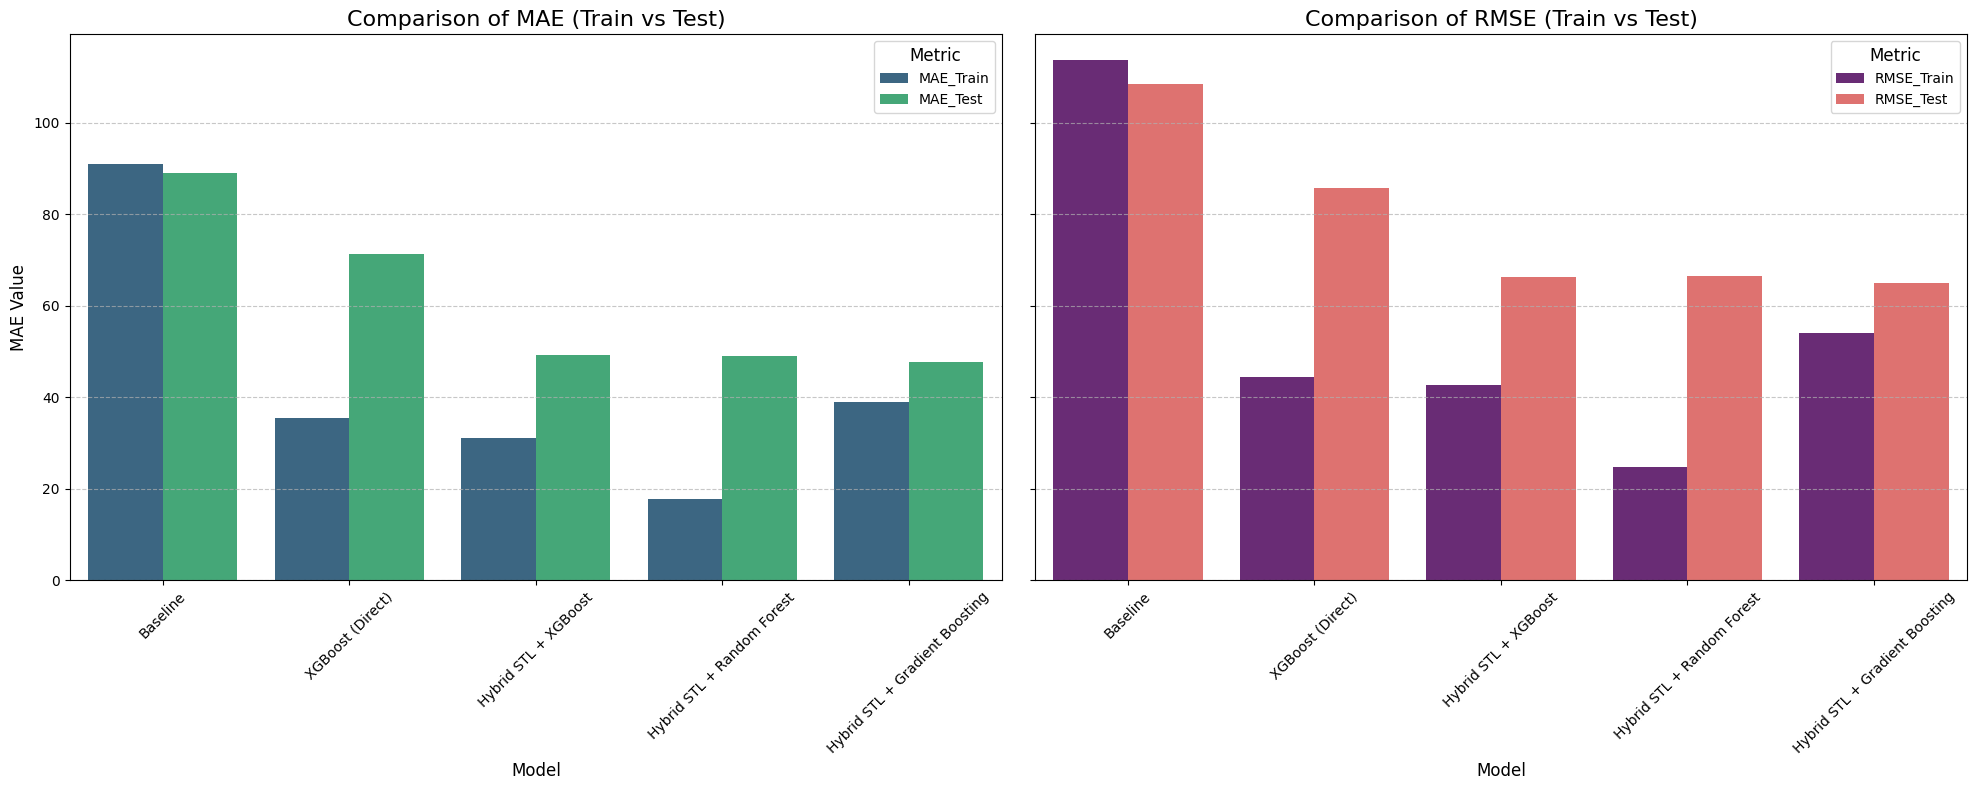


Among the models, the 'Hybrid STL + Gradient Boosting' is performing the best.
We know this because it has the lowest Test MAE (47.6585) and Test RMSE (65.0406) among all evaluated models. These metrics indicate its superior accuracy on unseen data.


In [25]:
# Set pandas display option for float format
pd.set_option('display.float_format', '{:.4f}'.format)

# Filter out Extra Trees and remove duplicates before creating the DataFrame
cleaned_model_metrics = []
model_names_seen = set()
for metric_entry in all_model_metrics:
    model_name = metric_entry['Model']
    if 'Extra Trees' not in model_name and model_name not in model_names_seen:
        cleaned_model_metrics.append(metric_entry)
        model_names_seen.add(model_name)

metrics_df = pd.DataFrame(cleaned_model_metrics)

print("\nSummary of Model Performance (Train and Test MAE/RMSE):\n")
display(metrics_df)

# Reset pandas display option to default to avoid affecting other outputs
pd.reset_option('display.float_format')

# Melt the DataFrame for easier plotting with seaborn
metrics_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Value')

# Create subplots for MAE and RMSE to improve clarity
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Plot MAE
sns.barplot(x='Model', y='Value', hue='Metric', data=metrics_melted[metrics_melted['Metric'].isin(['MAE_Train', 'MAE_Test'])], palette='viridis', ax=axes[0])
axes[0].set_title('Comparison of MAE (Train vs Test)', fontsize=16)
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('MAE Value', fontsize=12)
axes[0].tick_params(axis='x', rotation=45, labelsize=10)
axes[0].tick_params(axis='y', labelsize=10)
axes[0].legend(title='Metric', fontsize=10, title_fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot RMSE
sns.barplot(x='Model', y='Value', hue='Metric', data=metrics_melted[metrics_melted['Metric'].isin(['RMSE_Train', 'RMSE_Test'])], palette='magma', ax=axes[1])
axes[1].set_title('Comparison of RMSE (Train vs Test)', fontsize=16)
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('RMSE Value', fontsize=12)
axes[1].tick_params(axis='x', rotation=45, labelsize=10)
axes[1].tick_params(axis='y', labelsize=10)
axes[1].legend(title='Metric', fontsize=10, title_fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Determine the best performing model based on Test RMSE
best_model_row = metrics_df.loc[metrics_df['RMSE_Test'].idxmin()]
best_model_name = best_model_row['Model']
best_model_mae = best_model_row['MAE_Test']
best_model_rmse = best_model_row['RMSE_Test']

print(f"\nAmong the models, the '{best_model_name}' is performing the best.")
print(f"We know this because it has the lowest Test MAE ({best_model_mae:.4f}) and Test RMSE ({best_model_rmse:.4f}) among all evaluated models. These metrics indicate its superior accuracy on unseen data.")

## 14. Future Forecasting Using The Trained Hybrid STL + Gradient Boosting Model

In [26]:
import pandas as pd
import numpy as np
import holidays

# Dates for prediction
specific_dates = pd.to_datetime([
    '2026-01-28', '2026-01-29', '2026-01-30'
])

# Create a DataFrame for future dates
future_df = pd.DataFrame({'Date': specific_dates})

# Add calendar features
future_df['weekday'] = future_df['Date'].dt.weekday
future_df['is_weekend'] = future_df['weekday'].isin([5, 6]).astype(int)
future_df['month'] = future_df['Date'].dt.month

def get_season(month):
    if month in [3, 4, 5]:
        return 'summer'
    elif month in [6, 7, 8, 9]:
        return 'monsoon'
    else:
        return 'winter'
future_df['season'] = future_df['month'].apply(get_season)
future_df = pd.get_dummies(future_df, columns=['season'], drop_first=True)

# Ensure all season columns are present even if not in future_df
# This is crucial because `get_dummies` might not create columns if a category is missing
for col in ['season_summer', 'season_winter']:
    if col not in future_df.columns:
        future_df[col] = False

india_holidays = holidays.CountryHoliday('IN')
future_df['is_holiday'] = future_df['Date'].dt.date.apply(
    lambda x: 1 if x in india_holidays else 0
)

# --- Handle Lag Features ---
# Get the last known values for lag features from df_hybrid
# For simplicity, we'll use the last available values from the historical data
# In a real forecasting scenario, these would be iteratively updated or forecasted.
last_known_values = df_hybrid.iloc[-1]
future_df['lag_1'] = last_known_values['PredictedBloodDemand'] # Using last true demand for lag-1 for the first prediction
future_df['lag_3_avg'] = last_known_values['lag_3_avg']
future_df['lag_7_avg'] = last_known_values['lag_7_avg']
future_df['lag_14_avg'] = last_known_values['lag_14_avg']

# --- Handle STL Components (Trend and Seasonal) ---
# Extrapolate Trend: Use the last known trend value from df_hybrid
# This assumes a constant trend for these few future days, a simplification.
future_df['trend'] = df_hybrid['trend'].iloc[-1]

# Extrapolate Seasonal: Calculate average seasonal component per weekday from df_hybrid
# This assumes seasonal patterns remain consistent.
seasonal_by_weekday = df_hybrid.groupby(df_hybrid['Date'].dt.weekday)['seasonal'].mean()
future_df['seasonal'] = future_df['weekday'].map(seasonal_by_weekday)

# Prepare features for residual prediction
X_future = future_df[FEATURES_DIRECT]

# Predict residuals using the best model (gbr_res_model)
residual_preds_future = gbr_res_model.predict(X_future)

# Combine trend, seasonal, and residual predictions
future_df['Predicted Demand'] = (
    future_df['trend'] +
    future_df['seasonal'] +
    residual_preds_future
)

# Format the output as requested
output_df = future_df[['Date', 'Predicted Demand']].copy()
output_df['Predicted Demand'] = output_df['Predicted Demand'].round().astype(int)
output_df['Predicted Demand'] = output_df['Predicted Demand'].astype(str) + ' units'

display(output_df)

,Date,Predicted Demand
0,2026-01-28,261 units
1,2026-01-29,265 units
2,2026-01-30,268 units
